# Сравнение архитектур: CNN, RNN и SSM

## Введение

State Space Models, такие как Mamba, изначально разрабатывались для эффективного моделирования экстремально длинных последовательностей, где стандартные архитектуры становятся неэффиктивны.

Ярким примером таких данных является днк. В датасете HG38 (расшифрованый геном человека) средняя длина одной хромосомы составляет порядка 130 миллионов пар оснований (варьируясь от ~45 до ~248 млн). Чтобы эффективно работать с таким контекстом и находить глобальные закономерности, SSM (например, HyenaDNA или Mamba) обучаются на контекстных окнах длиной в миллионы токенов.

Стоит отметить важный технический нюанс: для достижения высокой скорости обучения и инференса на таких длинах стандартных операций PyTorch недостаточно. 
Для SSM критически важно писать кастомные CUDA-ядра, чтобы эффективно реализовать специфические операции и минимизировать задержки при работе с памятью GPU.

Однако в рамках этого семинара мы рассмотрим работу архитектуры на более простой задаче, чтобы понять базовые принципы работы SSM.

## Задача

В этом ноутбуке реализованы и сравниваются три модели для задачи `pixel-level 1‑D image classification`:

1. **LSTM** — разновидность RNN;
2. **1D CNN** — одномерная свёрточная сеть;
3. **S4D-Lin** — State Space Model из статьи [On the Parameterization and Initialization of Diagonal State Space Models](https://arxiv.org/abs/2206.11893).

Дополнительно рассмотрим **2D CNN** как baseline для `region-level image classification`, чтобы понять, можно ли при попиксельной классификации приблизиться к качеству 2D CNN или ViT.


## 0. Импорты и настройки

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Optional
from tqdm import tqdm


BATCH_SIZE = 256
SEQ_LEN = 28 * 28
INPUT_SIZE = 1
N_EPOCHS = 15
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cuda


## 1. Данные

Чтобы модели обучались достаточно быстро, возьмём датасет [MNIST](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html) — изображения рукописных цифр 28×28 в оттенках серого, 10 классов.

Для наших целей нужен датасет относительно длинных последовательностей, но MNIST — это двумерные картинки. Как превратить изображение в последовательность? Просто вытянем изображение в вектор по пикселям. Из таких вытянутых картинок составим датасет и будем называть его `sequential MNIST или sMNIST`.

In [ ]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.1307), (0.3081)),
])

class sMNIST(torch.utils.data.Dataset):
    """A wrapper dataset to transform 2D MNIST images into sequential data (sMNIST).

    This class takes a standard image dataset (like MNIST) and flattens the 
    images into a sequence of pixels. This is typically used to benchmark 
    sequence models on image data by treating the image 
    as a time series of length 784 (28x28).

    Args:
        dataset (torch.utils.data.Dataset): The underlying PyTorch dataset 
            (e.g., torchvision.datasets.MNIST).
        seq_len (int, optional): The total length of the flattened sequence. 
            Defaults to 784.
    """

    def __init__(self, dataset, seq_len=784):
        self.dataset = dataset
        self.seq_len = seq_len

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        """Retrieves a sample and reshapes it into a sequence.

        Args:
            idx (int): The index of the item to retrieve.

        Returns:
            Tuple[torch.Tensor, int]: A tuple containing:
                * The flattened image tensor with shape (seq_len, 1).
                * The integer class label.
        """

        img = self.dataset[idx][0]
        label = self.dataset[idx][1]
        return img.view(-1, 1), label

# 2D MNIST
mnist_dataset = {
    "train": torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform),
    "test":  torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform),
}

# 1D sMNIST
sMnist_dataset = {
    "train": sMNIST(mnist_dataset["train"], seq_len=SEQ_LEN),
    "test":  sMNIST(mnist_dataset["test"], seq_len=SEQ_LEN),
}

mnist_loader = {
    "train": DataLoader(mnist_dataset["train"], batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True),
    "test":  DataLoader(mnist_dataset["test"], batch_size=BATCH_SIZE, shuffle=False, num_workers=0),
}

sMnist_loader = {
    "train": DataLoader(sMnist_dataset["train"], batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True),
    "test":  DataLoader(sMnist_dataset["test"], batch_size=BATCH_SIZE, shuffle=False, num_workers=0),
}

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.3MB/s]


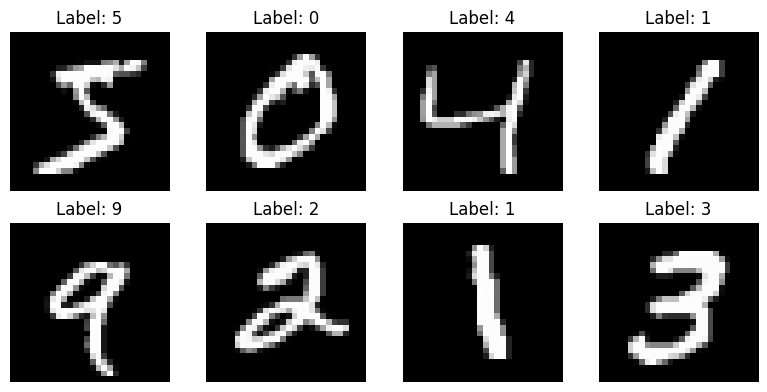

In [3]:
fig, axs = plt.subplots(2, 4, figsize=(8, 4))

for i, ax in enumerate(axs.flat):
    img, label = mnist_dataset["train"][i]
    img = img.squeeze(0)
    ax.imshow(img, cmap="gray")
    ax.set_title(f"Label: {label}")
    ax.axis("off")

plt.tight_layout()
plt.show()

## 2. 2D CNN

Свёрточная сеть обрабатывает изображение MNIST как тензор формы `(batch_size, 1, 28, 28)`. Сначала начальный свёрточный слой увеличивает число каналов до 16. Далее идут три residual‑блока: в каждом два свёрточных слоя `Conv2d → BatchNorm2d → ReLU/Dropout2d` и skip‑соединение. Во втором и третьем блоках пространственное разрешение уменьшается за счёт свёрток со `stride=2`, а число каналов увеличивается с 16 до 32 и затем до 64. После этого к выходным картам признаков применяется глобальный `AdaptiveAvgPool2d(1)`, и полученный вектор размерности 64 подаётся в линейный классификатор на 10 классов. Эта модель используется для 2D‑версии MNIST.

In [ ]:
class CNN(nn.Module):
    """A ResNet-style 2D Convolutional Neural Network for image classification.

    This network implements a lightweight Residual Network architecture designed
    for single-channel (grayscale) images. It consists of an initial convolution
    followed by three residual stages. The second and third stages perform
    downsampling and channel expansion using strided convolutions and 1x1 
    projection shortcuts.

    Architecture:
        1. Input Layer (1 channel -> 16 channels)
        2. Residual Block 1 (16 channels, stride 1)
        3. Residual Block 2 (16 -> 32 channels, stride 2, projection shortcut)
        4. Residual Block 3 (32 -> 64 channels, stride 2, projection shortcut)
        5. Global Average Pooling & Linear Classifier

    Args:
        num_classes (int, optional): The number of output classes. 
            Defaults to 10.
        dropout (float, optional): The dropout probability used in the 
            convolutional blocks. Defaults to 0.25.
    """

    def __init__(self, num_classes: int = 10, dropout: float = 0.25):
        super().__init__()

        self.conv0 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
        )

        self.conv1 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout2d(dropout),
        )

        self.down2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(32),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.Dropout2d(dropout),
        )

        self.down3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(64),
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.Dropout2d(dropout),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Defines the forward pass of the CNN.

        Processes the input through the convolutional stages with residual 
        connections, applies global average pooling, and projects to class logits.

        Args:
            x (torch.Tensor): Input image tensor. 
                Expected shape: (batch_size, 1, height, width).

        Returns:
            torch.Tensor: Class logits.
                Shape: (batch_size, num_classes).
        """
        
        x = self.conv0(x)

        identity = x
        out = self.conv1(x)
        x = torch.relu(out + identity)

        identity = self.down2(x)
        out = self.conv2(x)
        x = torch.relu(out + identity)

        identity = self.down3(x)
        out = self.conv3(x)
        x = torch.relu(out + identity)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

## 3. LSTM

Рекуррентная сеть получает на вход последовательность формы `(batch_size, seq_len, input_size)` — здесь это sMNIST длины 784. На каждом шаге в LSTM подаётся один скалярный признак (яркость пикселя). LSTM обрабатывает всю последовательность, а последний скрытый вектор используется как эмбеддинг картинки и подаётся в полносвязный классификатор для предсказания класса.

In [ ]:
class LSTM(nn.Module):
    """A standard LSTM-based Recurrent Neural Network for sequence classification.

    This model consists of a multi-layer Long Short-Term Memory (LSTM) encoder
    followed by a dropout layer and a linear classification head applied to the
    final hidden state.

    Args:
        input_size (int, optional): The number of expected features in the input `x`.
            Defaults to 1.
        hidden_size (int, optional): The number of features in the hidden state `h`.
            Defaults to 128.
        num_layers (int, optional): Number of recurrent layers. E.g., setting
            `num_layers=2` would mean stacking two LSTMs together to form a
            stacked LSTM, with the second LSTM taking in outputs of the first
            LSTM and computing the final results. Defaults to 2.
        num_classes (int, optional): The number of output classes. Defaults to 10.
        dropout (float, optional): If non-zero, introduces a Dropout layer on the
            outputs of each LSTM layer except the last layer, with probability
            equal to `dropout`. Also applied before the final linear layer.
            Defaults to 0.25.
    """
    
    def __init__(self, input_size: int = 1, hidden_size: int = 128, num_layers: int = 2, num_classes: int = 10, dropout: float = 0.25):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Defines the forward pass of the LSTM model.

        Passes the input sequence through the LSTM layers, extracts the output
        from the last time step, applies dropout, and projects it to the class space.

        Args:
            x (torch.Tensor): The input tensor containing the sequence features.
                Shape should be (batch_size, seq_len, input_size).

        Returns:
            torch.Tensor: The output logits.
                Shape will be (batch_size, num_classes).
        """

        out, (h_n, _) = self.lstm(x)
        logits = self.fc(self.dropout(out[:, -1, :]))
        return logits

## 4. 1D CNN

Одномерная свёрточная сеть обрабатывает последовательность формы `(batch_size, seq_len, input_size)` из sMNIST. Сначала вход транспонируется в `(batch_size, input_size, seq_len)` и подаётся в несколько блоков `Conv1d → BatchNorm1d → ReLU → MaxPool1d → Dropout1d`, которые постепенно уменьшают длину последовательности и увеличивают число каналов. Затем применяется глобальное усреднение `AdaptiveAvgPool1d(1)`, после чего полученный вектор признаков проходит через полносвязный классификатор и даёт логиты для 10 классов.

In [ ]:
class Conv1DModel(nn.Module):
    """A 1D Convolutional Neural Network for sequence classification.

    Constructs a series of convolutional blocks followed by adaptive pooling
    and a fully connected classifier. Each block consists of a 1D convolution, 
    batch normalization, ReLU activation, max pooling, and dropout.

    Args:
        input_size (int, optional): The number of input features/channels per 
            time step. Defaults to 1.
        channels (Tuple[int, ...], optional): A tuple defining the number of 
            output channels for each convolutional layer. The length of this 
            tuple determines the depth of the network. Defaults to (32, 64, 128).
        kernel_size (int, optional): The size of the convolving kernel. 
            Defaults to 7.
        num_classes (int, optional): The number of output classes. 
            Defaults to 10.
        dropout (float, optional): The dropout probability used in both the 
            convolutional blocks and the fully connected head. Defaults to 0.25.
    """

    def __init__(self, input_size: int = 1, channels: Tuple[int, ...] = (32, 64, 128),
                 kernel_size: int = 7, num_classes: int = 10, dropout: float = 0.25):
        super().__init__()
        layers = []
        in_c = input_size
        for out_c in channels:
            layers += [
                nn.Conv1d(in_c, out_c, kernel_size, padding=kernel_size // 2),
                nn.BatchNorm1d(out_c),
                nn.ReLU(inplace=True),
                nn.MaxPool1d(2),
                nn.Dropout1d(dropout),
            ]
            in_c = out_c
        self.conv = nn.Sequential(*layers)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_c, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Defines the forward pass of the model.

        Permutes the input tensor to match the channel-first format expected by
        PyTorch Conv1d layers, then passes it through the convolutional backbone,
        pooling layer, and classification head.

        Args:
            x (torch.Tensor): The input tensor with shape (batch_size, seq_len, input_size).

        Returns:
            torch.Tensor: The output logits with shape (batch_size, num_classes).
        """
        
        # x: (B, seq_len, input_size) -> (B, input_size, seq_len)
        x = x.permute(0, 2, 1)
        x = self.conv(x)
        x = self.pool(x)
        return self.fc(x)

## 5. Diagonal S4

В статье [On the Parameterization and Initialization of Diagonal State Space Models](https://arxiv.org/abs/2206.11893)(2022):

<div style="text-align:center">
<img src="https://raw.githubusercontent.com/SoulQrat/State-Space-Models/main/images/3.png" width="600" center>
</div>

- Вводят **Diagonal S4 (S4D)**: берут матрицу состояния **A диагональной** (в комплексном пространстве) вместо DPLR в S4
- Ядро свёртки тогда выражается через **степени** диагональных элементов $\bar A^\ell$ и сводится к умножению на **матрицу Вандермонда**
- Для устойчивости параметризуют так, чтобы $Re(\lambda(A)) < 0$ (действительная часть собственных значений матрицы $A$ отрицательна).
Если не выполнено, то при $t \to \infty$ значения $K=C e^{At} B$ взрываются.
- Дают простые инициализации диагонали, например **S4D-Lin**, которую мы будем использовать: $A_n=-\tfrac{1}{2}+i\pi n$

Такой метод проще в реализации и, как видно из таблицы ниже, по качеству в большинстве случаев близок к S4.

<div style="text-align:center">
<img src="https://raw.githubusercontent.com/SoulQrat/State-Space-Models/main/images/1.png" width="600" center>
</div>

### 5.1 Инциализация матрицы, ядро и свёртка

Следущие три функции в коде это имплементация данных функций на PyTorch.

<div style="text-align:center">
<img src="https://raw.githubusercontent.com/SoulQrat/State-Space-Models/main/images/2.png" width="600" center>
</div>

- **parameters**: Функция выбирает шаг дискретизации $\Delta t$ случайно в лог‑масштабе между $dt_{min}$ и $dt_{max}$, чтобы покрывать разные временные масштабы.
Дальше задаётся диагональная комплексная матрица $A$: отрицательная вещественная часть обеспечивает устойчивое затухание, а мнимая часть растёт линейно и задаёт набор частот (это и есть «Lin» в названии модели).​
Матрица $B$ инициализуется единицами, а $C$ инициализируется случайно.

- **kernel**: Функция сначала делает дискретизацию непрерывной модели в дискретную.
Затем она вычисляет свёрточное ядро $\overline{K}$ как сумму по диагональным компонентам вида $\overline{A}^l$ (это умножение на матрицу Вандермонда).
В конце берётся «удвоенная вещественная часть», что эквивалентно неявному добавлению комплексно‑сопряжённых пар и гарантирует вещественный результат для вещественного входа.

- **forward** Функция берёт длину входной последовательности $L$, строит ядро $K$ той же длины и применяет свёртку $y=u K$ ($u$ - input).
Чтобы сделать это быстро, свёртку считают через FFT (Fast Fourier Transform): делают FFT входа и ядра, перемножают в частотной области и делают обратное FFT, после чего обрезают результат до длины $L$.

Если хочется понять что такое Fourier Transform, можно посмотреть например это https://youtu.be/spUNpyF58BY?si=FLqZVtdRtm4xRWI7. 

Вообще обо всем этом можно думать так: $A$ задаёт набор «затухающих колебаний» (разные частоты и скорости затухания), из которых **kernel** собирает импульсную характеристику $K$ фильтра.
А **forward** просто фильтрует входную последовательность этим фильтром, причём делает это эффективно благодаря FFT.

In [7]:
def parameters(N_half: int, dt_min: float = 1e-3, dt_max: float = 1e-1,
                 device: torch.device = None) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """Initializes S4D-Lin diagonal SSM parameters (half-spectrum).

    This creates parameters for a diagonal continuous-time state matrix A whose eigenvalues
    are placed on a vertical line in the complex plane:
        A_n = -0.5 + i*pi*n,  n = 0..Nhalf-1
    (stored as separate real log-magnitude and imaginary part), plus a random log time-step
    and simple B/C initialization.

    Args:
        Nhalf: Half of the SSM state size (N must be even in the full model; we store N/2
            complex eigenvalues and later take 2*Re(...) to get a real kernel).
        dt_min: Minimum discretization step (log-uniform sampling range).
        dt_max: Maximum discretization step (log-uniform sampling range).
        device: Torch device to place tensors on (defaults to CPU).

    Returns:
        logdt: Tensor of shape (1,), sampled log(dt) (float32).
        logAreal: Tensor of shape (Nhalf,), log of positive magnitude for Re(A) (float32).
        Aimag: Tensor of shape (Nhalf,), imaginary parts of A (float32).
        B: Tensor of shape (Nhalf,), complex input vector (complex64).
        C: Tensor of shape (Nhalf,), complex output vector (complex64).
    """
    
    device = device or torch.device('cpu')
    log_dt = torch.rand(1, device=device, dtype=torch.float32) * (np.log(dt_max) - np.log(dt_min)) + np.log(dt_min)
    # A_n = -0.5 + 1j*π*n  =>  log_A_real = log(0.5), A_imag = π*n
    log_A_real = torch.full((N_half,), np.log(0.5), device=device, dtype=torch.float32)
    A_imag = np.pi * torch.arange(N_half, dtype=torch.float32, device=device)
    B = torch.ones(N_half, device=device, dtype=torch.complex64)
    C = (torch.randn(N_half, device=device, dtype=torch.float32) + 1j * torch.randn(N_half, device=device, dtype=torch.float32))
    return log_dt, log_A_real, A_imag, B, C

def kernel(log_dt: torch.Tensor, log_A_real: torch.Tensor, A_imag: torch.Tensor,
                   B: torch.Tensor, C: torch.Tensor, L: int) -> torch.Tensor:
    """Builds the real-valued S4D-Lin convolution kernel of length L.

    Discretizes the diagonal continuous-time SSM with a bilinear/Tustin-like transform:
        dA = (1 + (dt/2)A) / (1 - (dt/2)A)
        dB = dt * B / (1 - (dt/2)A)
    Then forms the kernel:
        K[l] = 2 * Re( sum_n (dB_n * C_n * dA_n^l) ), l=0..L-1

    Args:
        logdt: Shape (1,) or broadcastable; log time step.
        logAreal: Shape (Nhalf,); log magnitude for Re(A) (Re(A) = -exp(logAreal)).
        Aimag: Shape (Nhalf,); Im(A).
        B: Shape (Nhalf,), complex.
        C: Shape (Nhalf,), complex.
        L: Kernel length.

    Returns:
        K: Real kernel tensor of shape (L,).
    """

    dt = torch.exp(log_dt).clamp(min=1e-4)
    A = -torch.exp(log_A_real.clamp(max=10)) + 1j * A_imag
    dA = (1 + dt / 2 * A) / (1 - dt / 2 * A)
    dB = (dt * B) / (1 - dt / 2 * A)
    # Vandermonde: (N_half, L), V[n, l] = dA[n]**l
    l_range = torch.arange(L, device=dA.device, dtype=torch.float32)
    V = dA.unsqueeze(1) ** l_range.unsqueeze(0).to(dA.dtype)
    # K = 2 * real( (dB*C) @ V ); (dB*C) (N_half,), V (N_half, L) -> (L,)
    K = 2 * (dB * C).unsqueeze(0) @ V
    return K.squeeze(0).real


def forward(u: torch.Tensor, K: torch.Tensor) -> torch.Tensor:
    """Computes 1D causal convolution using FFT padding to 2L.

    Given u[..., L] and K[L], performs:
        y[t] = sum_{i=0..t} u[i] * K[t-i]
    implemented as linear convolution via FFT:
        pad both to length 2L, multiply spectra, inverse FFT, then truncate to L.

    Args:
        u: Input tensor with last dim = L (e.g., (B, H, L)).
        K: Kernel tensor with last dim = L.

    Returns:
        out: Tensor with same shape as u (last dim L).
    """

    L = u.shape[-1]
    n_fft = 2 * L
    u_pad = torch.nn.functional.pad(u, (0, L))
    K_pad = torch.nn.functional.pad(K, (0, L))
    U = torch.fft.rfft(u_pad, n=n_fft)
    K_ = torch.fft.rfft(K_pad, n=n_fft)
    while K_.dim() < U.dim():
        K_ = K_.unsqueeze(0)
    out = torch.fft.irfft(U * K_, n=n_fft)[..., :L]
    return out

### 5.3 S4D model

In [ ]:
class S4DLayer(nn.Module):
    """Diagonal S4D-Lin layer implemented as a convolution.

    This layer implements the Structured State Space sequence model (S4) using a 
    diagonal state matrix. It operates in the convolutional view, computing a 
    global convolution kernel K from the learned parameters.

    The layer stores N/2 complex parameters (representing the half-spectrum) and 
    converts them to a real kernel K via 2*Re(...). It also includes a learned 
    skip connection (scalar D) and an output projection.

    Args:
        H (int): The number of hidden features/channels in the input and output.
        N (int): The dimensionality of the state space.
        L (int): The maximum sequence length.
        dt_min (float, optional): Minimum value for the time-step parameter initialization. 
            Defaults to 1e-3.
        dt_max (float, optional): Maximum value for the time-step parameter initialization. 
            Defaults to 1e-1.
    """

    def __init__(self, H: int, N: int, L: int, dt_min: float = 1e-3, dt_max: float = 1e-1):
        super().__init__()
        self.H, self.N, self.L = H, N, L
        N_half = N // 2
        log_dt, log_A_real, A_imag, B, C = parameters(N_half, dt_min, dt_max, torch.device('cpu'))
        self.log_dt = nn.Parameter(log_dt)
        self.log_A_real = nn.Parameter(log_A_real)
        self.A_imag = nn.Parameter(A_imag)
        self.B_re = nn.Parameter(B.real.clone())
        self.B_im = nn.Parameter(torch.zeros_like(B.real))
        self.C_re = nn.Parameter(C.real.clone() * 0.5)
        self.C_im = nn.Parameter(C.imag.clone() * 0.5)
        self.D = nn.Parameter(torch.ones(1))
        self.proj = nn.Linear(H, H)

    def forward(self, u: torch.Tensor) -> torch.Tensor:
        """Defines the forward pass of the S4D layer.

        Constructs the convolution kernel from parameters, applies the convolution via 
        FFT (implied by the external `forward` function), adds the skip connection, 
        and applies the final linear projection.

        Args:
            u (torch.Tensor): Input tensor with shape (Batch, Length, Hidden).

        Returns:
            torch.Tensor: Output tensor with shape (Batch, Length, Hidden).
        """

        B, L, H = u.shape
        N_half = self.N // 2
        B_c = self.B_re + 1j * self.B_im
        C = self.C_re + 1j * self.C_im
        K = kernel(self.log_dt, self.log_A_real, self.A_imag, B_c, C, L)
        out = forward(u.permute(0, 2, 1), K)
        out = out.permute(0, 2, 1)
        out = out + self.D * u
        return self.proj(out)


class S4DBlock(nn.Module):
    """A residual block composed of an S4D layer, normalization, and activation.

    Structure: Input -> S4DLayer -> LayerNorm -> GELU -> Residual Add -> Output.

    Args:
        H (int): The number of hidden features/channels.
        N (int): The dimensionality of the state space for the S4D layer.
        L (int): The maximum sequence length.
    """

    def __init__(self, H: int, N: int, L: int):
        super().__init__()
        self.s4d = S4DLayer(H, N, L)
        self.norm = nn.LayerNorm(H)
        self.act = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Applies the residual S4D block to the input.

        Args:
            x (torch.Tensor): Input tensor with shape (Batch, Length, Hidden).

        Returns:
            torch.Tensor: Output tensor with shape (Batch, Length, Hidden).
        """
        
        return x + self.act(self.norm(self.s4d(x)))


class S4DModel(nn.Module):
    """Sequence classifier built using stacked S4D residual blocks.

    The processing pipeline is as follows:
    1. Linear embedding of inputs.
    2. Stack of residual S4D blocks.
    3. Layer Normalization.
    4. Global average pooling (mean over time).
    5. Dropout and Final Linear classification head.

    Args:
        input_size (int, optional): The number of input features per time step. 
            Defaults to 1.
        hidden_size (int, optional): The number of features in the hidden state. 
            Defaults to 64.
        num_layers (int, optional): The number of stacked S4D blocks. 
            Defaults to 2.
        N (int, optional): The dimensionality of the state space. Defaults to 64.
        seq_len (int, optional): The length of the input sequences. Defaults to 784.
        num_classes (int, optional): The number of output classes. Defaults to 10.
        dropout (float, optional): The dropout probability before the final classifier. 
            Defaults to 0.25.
    """

    def __init__(self, input_size: int = 1, hidden_size: int = 64, num_layers: int = 2,
                 N: int = 64, seq_len: int = 784, num_classes: int = 10, dropout: float = 0.25):
        super().__init__()
        self.embed = nn.Linear(input_size, hidden_size)
        self.blocks = nn.ModuleList([S4DBlock(hidden_size, N, seq_len) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Defines the forward pass for sequence classification.

        Args:
            x (torch.Tensor): Input tensor with shape (Batch, Length, Input Size).

        Returns:
            torch.Tensor: Logits with shape (Batch, Num Classes).
        """
        
        x = self.embed(x)
        for block in self.blocks:
            x = block(x)
        x = self.norm(x)
        x = x.mean(dim=1)
        return self.fc(self.dropout(x))

## 6. Обучение и оценка

- **count_parameters** — функция для подсчета числа параметров у модели

- **train_epoch** - одна эпоха обучения, возвращает loss и accuracy

- **evaluate** - тест, возвращает loss и accuracy

- **train** - `n_epochs` раз вызывает **train_epoch**, сохраняет историю обучения и итоговое качество на тесте

In [ ]:
results = []

def count_parameters(model):
    """Counts the total and trainable parameters of a PyTorch model.

    Args:
        model (nn.Module): The PyTorch model to inspect.

    Returns:
        dict: A dictionary containing:
            * "total_params" (int): The total number of parameters in the model.
            * "trainable_params" (int): The number of parameters that require gradients.
    """
     
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    return {"total_params": total_params, "trainable_params": trainable_params}

def train_epoch(model: nn.Module, loader: DataLoader, optimizer: optim.Optimizer, device: torch.device, max_norm: Optional[float] = None) -> Tuple[float, float]:
    """Trains the model for one epoch over the provided data loader.

    Iterates through the loader, computes loss, performs backpropagation, and updates
    model parameters. Optionally clips gradients if `max_norm` is provided.

    Args:
        model (nn.Module): The PyTorch model to train.
        loader (DataLoader): The DataLoader containing training data.
        optimizer (optim.Optimizer): The optimizer to use for parameter updates.
        device (torch.device): The device (CPU or GPU) to move data and model to.
        max_norm (float, optional): Maximum norm for gradient clipping. If None, 
            no gradient clipping is performed. Defaults to None.

    Returns:
        Tuple[float, float]: A tuple containing:
            * The average loss over the epoch.
            * The average accuracy over the epoch.
    """

    model.train()
    total_loss = 0.0
    accuracy = 0
    n = 0
    for x, y in tqdm(loader, desc='train'):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = nn.functional.cross_entropy(logits, y)
        loss.backward()
        if max_norm is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        accuracy += (logits.argmax(dim=1) == y).sum().item()
        n += x.size(0)
    return total_loss / n, accuracy / n


@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader, device: torch.device) -> Tuple[float, float]:
    """Evaluates the model's performance on a given dataset.

    Computes loss and accuracy without updating gradients (inference mode).

    Args:
        model (nn.Module): The PyTorch model to evaluate.
        loader (DataLoader): The DataLoader containing evaluation/test data.
        device (torch.device): The device (CPU or GPU) to perform evaluation on.

    Returns:
        Tuple[float, float]: A tuple containing:
            * The average loss over the dataset.
            * The average accuracy over the dataset.
    """

    model.eval()
    total_loss = 0.0
    accuracy = 0
    n = 0
    for x, y in tqdm(loader, desc='evaluate'):
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = nn.functional.cross_entropy(logits, y)
        total_loss += loss.item() * x.size(0)
        accuracy += (logits.argmax(dim=1) == y).sum().item()
        n += x.size(0)
    return total_loss / n, accuracy / n


def train(model: nn.Module, train_loader: DataLoader, test_loader: DataLoader, optimizer: optim.Optimizer, device: torch.device, n_epochs: int, max_norm: Optional[float] = None) -> dict:
    """Runs the full training loop for a specified number of epochs.

    Trains the model on `train_loader` and evaluates it on `test_loader` after 
    training is complete. Records loss and accuracy history.

    Args:
        model (nn.Module): The PyTorch model to train.
        train_loader (DataLoader): DataLoader for training data.
        test_loader (DataLoader): DataLoader for validation/testing data.
        optimizer (optim.Optimizer): Optimizer for model updates.
        device (torch.device): Device to run training on.
        n_epochs (int): Number of total epochs to train.
        max_norm (float, optional): Gradient clipping value passed to `train_epoch`. 
            Defaults to None.

    Returns:
        dict: A dictionary containing training history:
            * 'train_loss' (List[float]): List of average training losses per epoch.
            * 'train_acc' (List[float]): List of average training accuracies per epoch.
            * 'test_loss' (float): Final average loss on the test set.
            * 'test_acc' (float): Final average accuracy on the test set.
            * 'total_params' (int): Total parameter count of the model.
    """
    
    history = {
        'train_loss': [], 'train_acc': [],
        'test_loss': None, 'test_acc': None,
        'total_params': count_parameters(model)["total_params"],
    }
    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, device, max_norm)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        print(f'Epoch {epoch+1:2d}/{n_epochs} train_loss={train_loss:.4f}  train_acc={train_acc:.4f} ')
    test_loss, test_acc = evaluate(model, test_loader, device)
    history['test_loss'] = test_loss
    history['test_acc'] = test_acc
    print(f'test_loss={test_loss:.4f}  test_acc={test_acc:.4f}')
    return history

### 6.1 CNN (2D)

In [10]:
model_cnn = CNN(num_classes=10).to(DEVICE)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

history = train(model_cnn, mnist_loader["train"], mnist_loader["test"], optimizer, DEVICE, N_EPOCHS)
history["Model"] = "2D CNN"
results.append(history)

train: 100%|██████████| 235/235 [00:07<00:00, 32.06it/s]


Epoch  1/15 train_loss=1.3110  train_acc=0.5964 


train: 100%|██████████| 235/235 [00:06<00:00, 35.96it/s]


Epoch  2/15 train_loss=0.3221  train_acc=0.9249 


train: 100%|██████████| 235/235 [00:06<00:00, 35.47it/s]


Epoch  3/15 train_loss=0.1783  train_acc=0.9550 


train: 100%|██████████| 235/235 [00:06<00:00, 36.45it/s]


Epoch  4/15 train_loss=0.1296  train_acc=0.9661 


train: 100%|██████████| 235/235 [00:06<00:00, 36.08it/s]


Epoch  5/15 train_loss=0.1047  train_acc=0.9725 


train: 100%|██████████| 235/235 [00:06<00:00, 35.92it/s]


Epoch  6/15 train_loss=0.0892  train_acc=0.9760 


train: 100%|██████████| 235/235 [00:06<00:00, 37.13it/s]


Epoch  7/15 train_loss=0.0793  train_acc=0.9781 


train: 100%|██████████| 235/235 [00:06<00:00, 36.04it/s]


Epoch  8/15 train_loss=0.0722  train_acc=0.9800 


train: 100%|██████████| 235/235 [00:06<00:00, 36.34it/s]


Epoch  9/15 train_loss=0.0670  train_acc=0.9817 


train: 100%|██████████| 235/235 [00:06<00:00, 36.14it/s]


Epoch 10/15 train_loss=0.0614  train_acc=0.9828 


train: 100%|██████████| 235/235 [00:06<00:00, 36.12it/s]


Epoch 11/15 train_loss=0.0568  train_acc=0.9845 


train: 100%|██████████| 235/235 [00:06<00:00, 36.36it/s]


Epoch 12/15 train_loss=0.0524  train_acc=0.9855 


train: 100%|██████████| 235/235 [00:06<00:00, 36.55it/s]


Epoch 13/15 train_loss=0.0505  train_acc=0.9862 


train: 100%|██████████| 235/235 [00:06<00:00, 36.46it/s]


Epoch 14/15 train_loss=0.0488  train_acc=0.9864 


train: 100%|██████████| 235/235 [00:06<00:00, 36.07it/s]


Epoch 15/15 train_loss=0.0459  train_acc=0.9864 


evaluate: 100%|██████████| 40/40 [00:01<00:00, 21.64it/s]

test_loss=0.0281  test_acc=0.9912


### 6.2 LSTM

In [11]:
model_lstm = LSTM(input_size=INPUT_SIZE, hidden_size=128, num_layers=2, num_classes=10, dropout=0.1).to(DEVICE)
optimizer = optim.AdamW(model_lstm.parameters(), lr=1e-4)

history = train(model_lstm, sMnist_loader["train"], sMnist_loader["test"], optimizer, DEVICE, N_EPOCHS, max_norm=1.0)
history["Model"] = "LSTM"
results.append(history)

train: 100%|██████████| 235/235 [00:31<00:00,  7.51it/s]


Epoch  1/15 train_loss=2.3017  train_acc=0.1094 


train: 100%|██████████| 235/235 [00:31<00:00,  7.43it/s]


Epoch  2/15 train_loss=2.3014  train_acc=0.1124 


train: 100%|██████████| 235/235 [00:30<00:00,  7.60it/s]


Epoch  3/15 train_loss=2.3013  train_acc=0.1124 


train: 100%|██████████| 235/235 [00:31<00:00,  7.56it/s]


Epoch  4/15 train_loss=2.3013  train_acc=0.1124 


train: 100%|██████████| 235/235 [00:31<00:00,  7.47it/s]


Epoch  5/15 train_loss=2.2968  train_acc=0.1213 


train: 100%|██████████| 235/235 [00:33<00:00,  7.04it/s]


Epoch  6/15 train_loss=1.9843  train_acc=0.2490 


train: 100%|██████████| 235/235 [00:33<00:00,  7.03it/s]


Epoch  7/15 train_loss=1.8269  train_acc=0.3298 


train: 100%|██████████| 235/235 [00:33<00:00,  7.03it/s]


Epoch  8/15 train_loss=1.6057  train_acc=0.4373 


train: 100%|██████████| 235/235 [00:33<00:00,  7.04it/s]


Epoch  9/15 train_loss=1.6568  train_acc=0.4014 


train: 100%|██████████| 235/235 [00:33<00:00,  7.03it/s]


Epoch 10/15 train_loss=1.5744  train_acc=0.4264 


train: 100%|██████████| 235/235 [00:33<00:00,  7.04it/s]


Epoch 11/15 train_loss=1.5396  train_acc=0.4273 


train: 100%|██████████| 235/235 [00:33<00:00,  7.03it/s]


Epoch 12/15 train_loss=1.5072  train_acc=0.4317 


train: 100%|██████████| 235/235 [00:33<00:00,  7.04it/s]


Epoch 13/15 train_loss=1.4833  train_acc=0.4358 


train: 100%|██████████| 235/235 [00:33<00:00,  7.04it/s]


Epoch 14/15 train_loss=1.4669  train_acc=0.4392 


train: 100%|██████████| 235/235 [00:33<00:00,  7.04it/s]


Epoch 15/15 train_loss=1.4458  train_acc=0.4413 


evaluate: 100%|██████████| 40/40 [00:04<00:00,  8.12it/s]

test_loss=1.4401  test_acc=0.4357


### 6.3 1D-CNN

In [12]:
model_1d = Conv1DModel(input_size=INPUT_SIZE, num_classes=10).to(DEVICE)
optimizer = optim.Adam(model_1d.parameters(), lr=1e-3)

history = train(model_1d, sMnist_loader["train"], sMnist_loader["test"], optimizer, DEVICE, N_EPOCHS)
history["Model"] = "1D CNN"
results.append(history)

train: 100%|██████████| 235/235 [00:11<00:00, 19.99it/s]


Epoch  1/15 train_loss=1.7448  train_acc=0.3622 


train: 100%|██████████| 235/235 [00:11<00:00, 19.61it/s]


Epoch  2/15 train_loss=1.3259  train_acc=0.5167 


train: 100%|██████████| 235/235 [00:11<00:00, 19.70it/s]


Epoch  3/15 train_loss=1.1571  train_acc=0.5768 


train: 100%|██████████| 235/235 [00:11<00:00, 19.81it/s]


Epoch  4/15 train_loss=1.0393  train_acc=0.6231 


train: 100%|██████████| 235/235 [00:11<00:00, 19.73it/s]


Epoch  5/15 train_loss=0.9521  train_acc=0.6567 


train: 100%|██████████| 235/235 [00:11<00:00, 19.80it/s]


Epoch  6/15 train_loss=0.8951  train_acc=0.6803 


train: 100%|██████████| 235/235 [00:11<00:00, 20.02it/s]


Epoch  7/15 train_loss=0.8429  train_acc=0.6989 


train: 100%|██████████| 235/235 [00:11<00:00, 19.75it/s]


Epoch  8/15 train_loss=0.7900  train_acc=0.7228 


train: 100%|██████████| 235/235 [00:11<00:00, 19.90it/s]


Epoch  9/15 train_loss=0.7481  train_acc=0.7378 


train: 100%|██████████| 235/235 [00:11<00:00, 19.67it/s]


Epoch 10/15 train_loss=0.7084  train_acc=0.7576 


train: 100%|██████████| 235/235 [00:11<00:00, 19.74it/s]


Epoch 11/15 train_loss=0.6645  train_acc=0.7737 


train: 100%|██████████| 235/235 [00:11<00:00, 19.93it/s]


Epoch 12/15 train_loss=0.6328  train_acc=0.7859 


train: 100%|██████████| 235/235 [00:11<00:00, 19.86it/s]


Epoch 13/15 train_loss=0.5958  train_acc=0.7998 


train: 100%|██████████| 235/235 [00:11<00:00, 19.89it/s]


Epoch 14/15 train_loss=0.5611  train_acc=0.8141 


train: 100%|██████████| 235/235 [00:11<00:00, 20.04it/s]


Epoch 15/15 train_loss=0.5388  train_acc=0.8217 


evaluate: 100%|██████████| 40/40 [00:03<00:00, 11.27it/s]

test_loss=0.3695  test_acc=0.8839


### 6.4 S4D-Lin

In [13]:
model_s4d = S4DModel(input_size=INPUT_SIZE, hidden_size=128, num_layers=3, N=64, seq_len=SEQ_LEN, num_classes=10).to(DEVICE)
optimizer = optim.Adam(model_s4d.parameters(), lr=1e-3)

history = train(model_s4d, sMnist_loader["train"], sMnist_loader["test"], optimizer, DEVICE, N_EPOCHS)
history["Model"] = "S4D-Lin"
results.append(history)

train: 100%|██████████| 235/235 [00:47<00:00,  4.91it/s]


Epoch  1/15 train_loss=1.3943  train_acc=0.5515 


train: 100%|██████████| 235/235 [00:46<00:00,  5.04it/s]


Epoch  2/15 train_loss=0.6972  train_acc=0.7699 


train: 100%|██████████| 235/235 [00:46<00:00,  5.02it/s]


Epoch  3/15 train_loss=0.5377  train_acc=0.8291 


train: 100%|██████████| 235/235 [00:46<00:00,  5.04it/s]


Epoch  4/15 train_loss=0.3976  train_acc=0.8783 


train: 100%|██████████| 235/235 [00:46<00:00,  5.03it/s]


Epoch  5/15 train_loss=0.3152  train_acc=0.9046 


train: 100%|██████████| 235/235 [00:46<00:00,  5.03it/s]


Epoch  6/15 train_loss=0.2618  train_acc=0.9211 


train: 100%|██████████| 235/235 [00:46<00:00,  5.02it/s]


Epoch  7/15 train_loss=0.2343  train_acc=0.9286 


train: 100%|██████████| 235/235 [00:46<00:00,  5.02it/s]


Epoch  8/15 train_loss=0.2135  train_acc=0.9344 


train: 100%|██████████| 235/235 [00:46<00:00,  5.02it/s]


Epoch  9/15 train_loss=0.1948  train_acc=0.9407 


train: 100%|██████████| 235/235 [00:46<00:00,  5.02it/s]


Epoch 10/15 train_loss=0.1841  train_acc=0.9443 


train: 100%|██████████| 235/235 [00:46<00:00,  5.02it/s]


Epoch 11/15 train_loss=0.1733  train_acc=0.9457 


train: 100%|██████████| 235/235 [00:46<00:00,  5.02it/s]


Epoch 12/15 train_loss=0.1653  train_acc=0.9489 


train: 100%|██████████| 235/235 [00:46<00:00,  5.02it/s]


Epoch 13/15 train_loss=0.1569  train_acc=0.9520 


train: 100%|██████████| 235/235 [00:46<00:00,  5.02it/s]


Epoch 14/15 train_loss=0.1482  train_acc=0.9539 


train: 100%|██████████| 235/235 [00:46<00:00,  5.02it/s]


Epoch 15/15 train_loss=0.1481  train_acc=0.9544 


evaluate: 100%|██████████| 40/40 [00:06<00:00,  6.12it/s]

test_loss=0.1283  test_acc=0.9580


## 7. Сравнение результатов

Test results
----------------------------------------------------------------------
Model: 2D CNN    params_cnt= 77,754  accuracy=0.9912  loss=0.0281
Model: LSTM      params_cnt=200,458  accuracy=0.4357  loss=1.4401
Model: 1D CNN    params_cnt= 90,378  accuracy=0.8839  loss=0.3695
Model: S4D-Lin   params_cnt= 52,688  accuracy=0.9580  loss=0.1283
----------------------------------------------------------------------


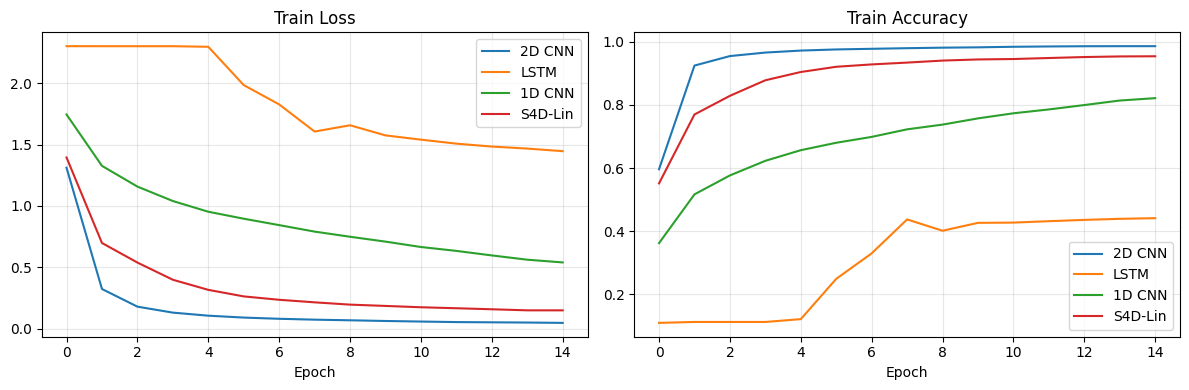

In [14]:
print('Test results')
print('-' * 70)
for h in results:
    print(f"Model: {h['Model']:8s}  params_cnt={h['total_params']:7,d}  accuracy={h['test_acc']:.4f}  loss={h['test_loss']:.4f}")
print('-' * 70)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

for h in results:
    axs[0].plot(h["train_loss"], label=h["Model"])
    axs[1].plot(h["train_acc"], label=h["Model"])

axs[0].set_title("Train Loss")
axs[1].set_title("Train Accuracy")

for ax in axs.flat:
    ax.set_xlabel("Epoch")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [15]:
# Prepared using Gemini 3 Pro (Write PyTorch benchmarking script to compare the inference performance)

import pandas as pd

def benchmark_model(model, input_shape, batch_size=64, device='cuda', n_warmup=10, n_runs=100):
    """
    Измеряет время инференса, пропускную способность и потребление памяти.
    """
    model = model.to(device)
    model.eval()
    
    # Генерируем случайный тензор нужной размерности
    input_data = torch.randn(batch_size, *input_shape).to(device)
    
    # 1. Warm-up (прогрев)
    # Необходим для инициализации CUDA контекста и кэшей, чтобы замеры были честными
    with torch.no_grad():
        for _ in range(n_warmup):
            _ = model(input_data)
    
    # Синхронизация перед началом замеров
    torch.cuda.synchronize()
    
    # 2. Замер времени с помощью CUDA Events
    start_events = [torch.cuda.Event(enable_timing=True) for _ in range(n_runs)]
    end_events = [torch.cuda.Event(enable_timing=True) for _ in range(n_runs)]
    
    # 3. Замер памяти
    torch.cuda.reset_peak_memory_stats(device)
    
    timings = []
    
    with torch.no_grad():
        for i in range(n_runs):
            start_events[i].record()
            _ = model(input_data)
            end_events[i].record()
    
    # Ждем завершения всех событий
    torch.cuda.synchronize()
    
    # Считаем время для каждого прогона
    for i in range(n_runs):
        timings.append(start_events[i].elapsed_time(end_events[i])) # Время в миллисекундах
    
    timings = np.array(timings)
    
    # Считаем метрики
    mean_latency_ms = np.mean(timings)
    std_latency_ms = np.std(timings)
    throughput = (batch_size * 1000) / mean_latency_ms # samples per second
    max_memory = torch.cuda.max_memory_allocated(device) / 1024 / 1024 # MB
    
    return {
        "Params": sum(p.numel() for p in model.parameters()),
        "Latency (ms)": f"{mean_latency_ms:.2f} ± {std_latency_ms:.2f}",
        "Throughput (img/s)": int(throughput),
        "Peak Memory (MB)": f"{max_memory:.2f}"
    }

In [16]:
bench_results = []

models_dict = {
    "LSTM": (model_lstm, (SEQ_LEN, 1)),
    "1D CNN": (model_1d, (SEQ_LEN, 1)),
    "S4D-Lin": (model_s4d, (SEQ_LEN, 1)),
    "2D CNN": (model_cnn, (1, 28, 28)),
}

for name, (model, shape) in models_dict.items():
    res = benchmark_model(model, shape, batch_size=BATCH_SIZE, device=DEVICE)
    res["Model"] = name
    bench_results.append(res)

In [17]:
pd.DataFrame(bench_results).set_index("Model")

,Params,Latency (ms),Throughput (img/s),Peak Memory (MB)
Model,,,,
LSTM,200458,49.47 ± 0.47,5174,2198.94
1D CNN,90378,5.91 ± 0.03,43346,114.84
S4D-Lin,52688,81.60 ± 0.47,3137,1296.43
2D CNN,77754,3.64 ± 0.03,70260,70.66


## 8. Выводы

В ходе работы была реализована и протестирована модель S4D-Lin для задачи классификации последовательностей на датасете sMNIST. По результатам экспериментов можно сделать следующие выводы:

- Модель S4D хорошо справляется с задачей sMNIST, где изображение $28 \times 28$ преобразуется в одномерную последовательность длиною 784 пикселя. Это подтверждает способность SSM эффективно улавливать долгосрочные зависимости. 
- S4D приблизилась к результату 2D CNN, несмотря на то, что S4D не имеет доступа к пространственной структуре изображения и обрабатывает данные исключительно как временной ряд.
- LSTM не смогла обучиться из-за проблемы затухания градиента на длинной последовательности.

## 9. Источники и материалы
- https://newsletter.maartengrootendorst.com/p/a-visual-guide-to-mamba-and-state
- https://www.ibm.com/think/topics/mamba-model
- https://github.com/ashaba1in/hse-nlp
- https://youtu.be/luCBXCErkCs?si=oS9g_dWR7GolS-w-
- https://youtu.be/yceNl9C6Ir0?si=MfTPDB3NkrsBn3eD
- https://tridao.me/blog/2024/mamba2-part1-model/
- [HiPPO: Recurrent Memory with Optimal Polynomial Projections](https://arxiv.org/abs/2008.07669) (2020)
- [Efficiently Modeling Long Sequences with Structured State Spaces](https://arxiv.org/abs/2111.00396) (2021)
- [Hungry Hungry Hippos: Towards Language Modeling with State Space Models](https://arxiv.org/abs/2212.14052) (2022)
- [On the Parameterization and Initialization of Diagonal State Space Models](https://arxiv.org/abs/2206.11893) (2022)
- [Mamba: Linear-Time Sequence Modeling with Selective State Spaces](https://arxiv.org/abs/2312.00752) (2023)
- [Transformers are SSMs: Generalized Models and Efficient Algorithms Through Structured State Space Duality](https://arxiv.org/abs/2405.21060) (2024)